# Computing Depth Maps

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import scipy.signal
import cv2 as cv
import time

# load static parameters manually

# load intrinsic camera matrix
ip = np.array([[2759.48, 0,       1520.69],
               [0,       2764.16, 1006.81],
               [0,       0,       1      ]])


# load external parameters of camera
ep_10 = np.array([[0.70735,   0.706534,   0.0215749 ],
                  [0.0218279, -0.0523403, 0.998391  ],
                  [0.706526,  -0.705741 , -0.0524451]])
ep_09 = np.array([[0.84137,    0.540262,   0.0145864 ],
                  [0.00860137, -0.0403709, 0.999148  ],
                  [0.540391,   -0.840528,  -0.0386139]])
ep_08 = np.array([[0.928942,    0.370116,   0.00895096 ],
                  [0.000956298, -0.0265758, 0.999646   ],
                  [0.370223,    -0.928605,  -0.0250414 ]]) 
ep_07 = np.array([[0.995535,   0.0943815, -0.00170578],
                  [0.003721,  -0.02118,   0.999769   ],
                  [0.0943235, -0.995311,  -0.0214366 ]])
ep_06 = np.array([[0.994915,    -0.100715,  0.00117536],
                  [-0.00462005, -0.0339759, 0.999412  ],
                  [-0.100616,   -0.994335,  -0.0342684]])
ep_05 = np.array([[0.962742,   -0.270399,  0.00344709],
                  [-0.0160548, -0.0444283, 0.998884  ],
                  [-0.269944,  -0.961723,  -0.0471142]])
ep_04 = np.array([[0.890856,   -0.454283,  -0.00158434],
                  [-0.0211638, -0.0449857, 0.998763   ],
                  [-0.453793,  -0.889721,  -0.0496901 ]])
ep_03 = np.array([[0.795163,  -0.606377,  -0.00477103],
                  [-0.050195, -0.0736593, 0.996019   ],
                  [-0.604314, -0.791759,  -0.0890082 ]])
ep_02 = np.array([[0.666779,   -0.74495,   0.021334  ],
                  [-0.0831384, -0.0459057, 0.99548   ],
                  [-0.740603,  -0.665539 , -0.0925429]])
ep_01 = np.array([[0.582226,   -0.813027,  -0.000148752],
                  [-0.0983866, -0.0706383, 0.992638    ],
                  [-0.807052,  -0.577925,  -0.121118   ]])
ep_00 = np.array([[0.450927,   -0.892535,  0.00679989],
                  [-0.0945642, -0.0401974, 0.994707  ],
                  [-0.887537,  -0.449183 , -0.102528 ]])



# load camera positions
cmpos_10 = np.array([-21.9937, -5.82033, -0.0463931])
cmpos_09 = np.array([-20.9553, -4.61897, -0.0303931])
cmpos_08 = np.array([-19.6309, -3.81958, -0.00781603])
cmpos_07 = np.array([-17.6302, -3.36186, 0.0325247])
cmpos_06 = np.array([-15.8818, -3.15083, 0.0592619])
cmpos_05 = np.array([-14.1604, -3.32084, 0.0862032])
cmpos_04 = np.array([-12.404,  -3.81315, 0.110559 ])
cmpos_03 = np.array([-10.8142, -4.53704, 0.122293 ])
cmpos_02 = np.array([-9.46627, -5.58174, 0.147736 ])
cmpos_01 = np.array([-8.31326, -6.3181,  0.16107  ])
cmpos_00 = np.array([-7.28137, -7.57667, 0.204446 ])

# load picture resolution
resolution = (3072, 2048)

# load 3D bounds
bound_10 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_09 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_08 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_07 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound above
bound_06 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_05 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_04 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound below
bound_03 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_02 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_01 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
bound_00 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))

In [2]:
#load images
def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

img0 = load_image('fountain_dense_images/0000.png')[:, :, 0]
img1 = load_image('fountain_dense_images/0001.png')[:, :, 0]
img2 = load_image('fountain_dense_images/0002.png')[:, :, 0]
img3 = load_image('fountain_dense_images/0003.png')[:, :, 0]
img4 = load_image('fountain_dense_images/0004.png')[:, :, 0]
img5 = load_image('fountain_dense_images/0005.png')[:, :, 0]
img6 = load_image('fountain_dense_images/0006.png')[:, :, 0]
img7 = load_image('fountain_dense_images/0007.png')[:, :, 0]
img8 = load_image('fountain_dense_images/0008.png')[:, :, 0]
img9 = load_image('fountain_dense_images/0009.png')[:, :, 0]
img10 = load_image('fountain_dense_images/0010.png')[:, :, 0]

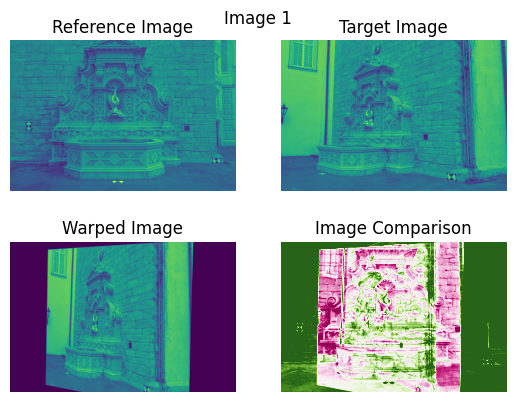

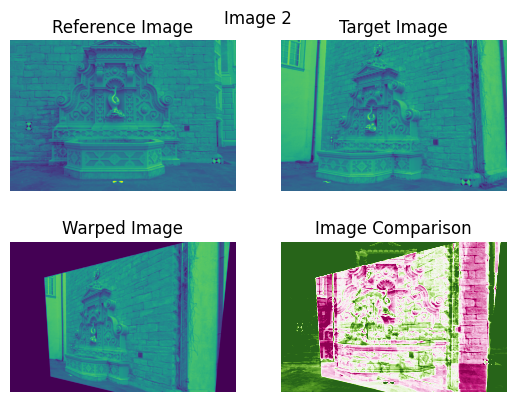

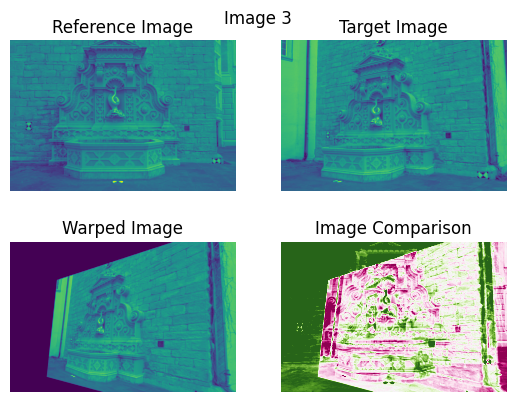

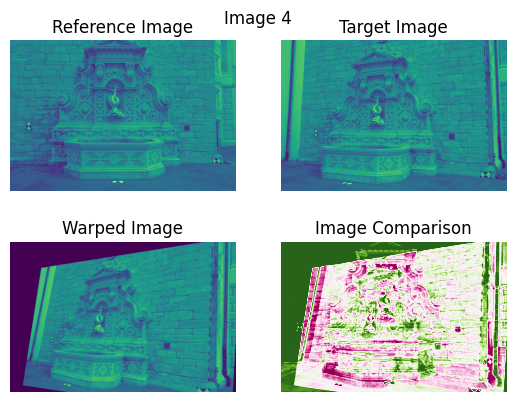

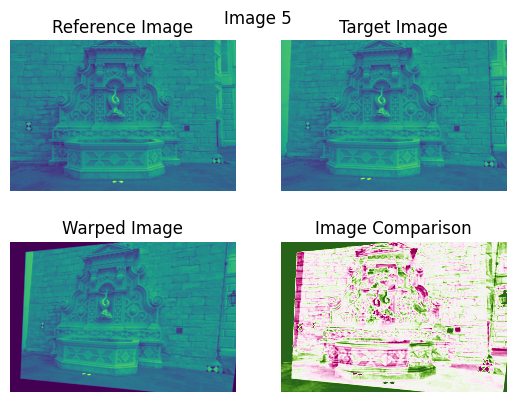

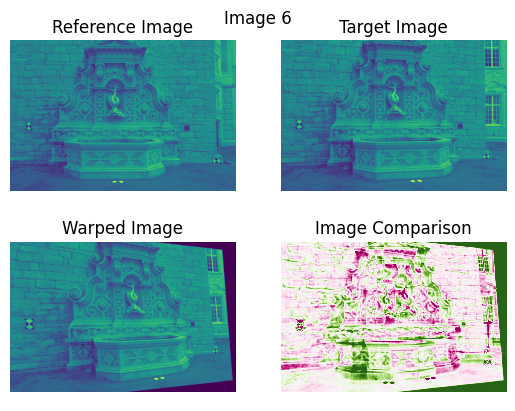

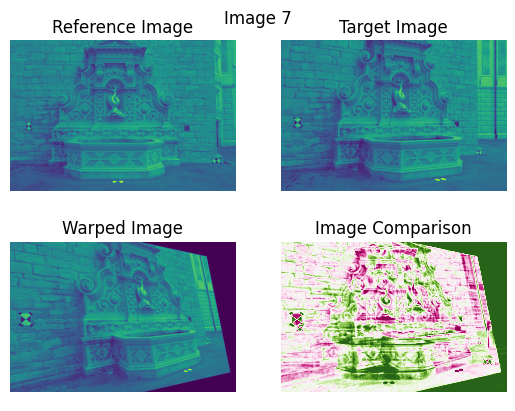

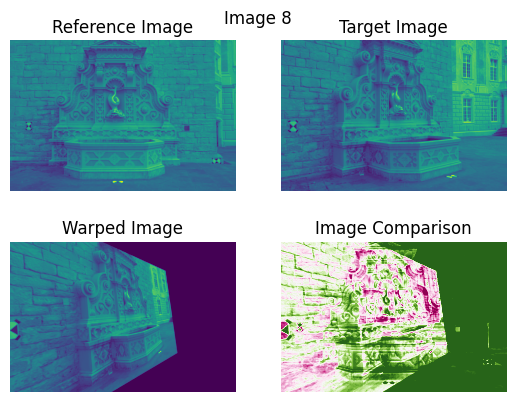

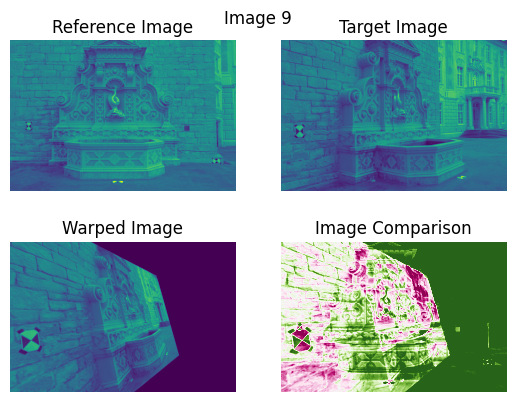

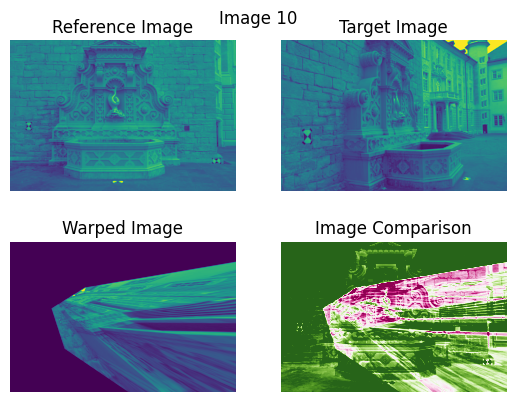

In [5]:
#Compute Homographies

def compute_translation_mat(image_transformed, image_base):
    # From: https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html
    img1 = (image_base*255).astype(np.uint8)
    img2 = (image_transformed*255).astype(np.uint8)
    MIN_MATCH_COUNT = 10
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    H, _ = cv.findHomography(src_pts, dst_pts)
    return H

extrinsic_matrices = [ep_00, ep_01, ep_02, ep_03, ep_04, ep_05, ep_06, ep_07, ep_08, ep_09, ep_10]

imgs = [img0, img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]

positions = [cmpos_00, cmpos_01, cmpos_02, cmpos_03, cmpos_04, cmpos_05, cmpos_06, cmpos_07, cmpos_08, cmpos_09, cmpos_10]

base_camera_matrix = np.dot(ip, extrinsic_matrices[5])

K = ip
K_inv = np.linalg.inv(K)
new_imgs = []
for i in range(len(imgs)):
    if i == 5:
        continue
    
    H = compute_translation_mat(imgs[i], imgs[5])
    newImg = cv.warpPerspective(imgs[i],H,(resolution[0], resolution[1]),flags=cv.INTER_LINEAR)
    new_imgs.append(newImg)

    plt.figure()
    plt.axis('off')
    if i >= 5:
         plt.title(f'Image {i}')
    else:
         plt.title(f'Image {i+1}')
    
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.title('Reference Image')
    plt.imshow(img5)
    
    plt.subplot(2,2,2)
    plt.axis('off')
    plt.title('Target Image')
    plt.imshow(imgs[i])
    
    plt.subplot(2,2,3)
    plt.axis('off')
    plt.title('Warped Image')
    plt.imshow(newImg)
    
    plt.subplot(2,2,4)
    plt.axis('off')
    plt.title('Image Comparison')
    plt.imshow(imgs[5] - newImg, vmin=-0.3, vmax=0.3, cmap='PiYG')

Progress: 0/20
Progress: 1/20
Progress: 2/20
Progress: 3/20
Progress: 4/20
Progress: 5/20
Progress: 6/20
Progress: 7/20
Progress: 8/20
Progress: 9/20
Progress: 10/20
Progress: 11/20
Progress: 12/20
Progress: 13/20
Progress: 14/20
Progress: 15/20
Progress: 16/20
Progress: 17/20
Progress: 18/20
Progress: 19/20
Progress: 0/20
Progress: 1/20
Progress: 2/20
Progress: 3/20
Progress: 4/20
Progress: 5/20
Progress: 6/20
Progress: 7/20
Progress: 8/20
Progress: 9/20
Progress: 10/20
Progress: 11/20
Progress: 12/20
Progress: 13/20
Progress: 14/20
Progress: 15/20
Progress: 16/20
Progress: 17/20
Progress: 18/20
Progress: 19/20
Progress: 0/20
Progress: 1/20
Progress: 2/20
Progress: 3/20
Progress: 4/20
Progress: 5/20
Progress: 6/20
Progress: 7/20
Progress: 8/20
Progress: 9/20
Progress: 10/20
Progress: 11/20
Progress: 12/20
Progress: 13/20
Progress: 14/20
Progress: 15/20
Progress: 16/20
Progress: 17/20
Progress: 18/20
Progress: 19/20
Progress: 0/20
Progress: 1/20
Progress: 2/20
Progress: 3/20
Progress: 

Text(0.5, 1.0, 'Depth Map (SSD)')

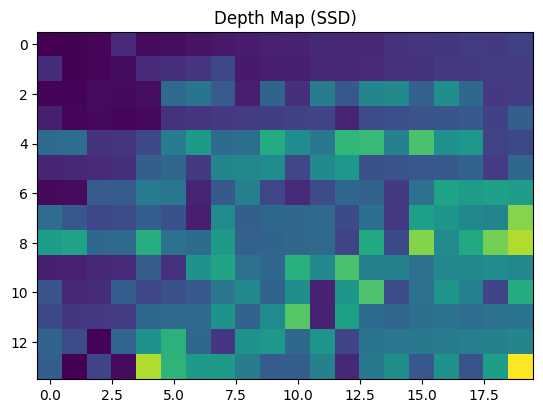

In [9]:
# Get image patches
def get_patch(image, x, y, patch_half_width):
    return image[y-patch_half_width:y+patch_half_width+1,
                 x-patch_half_width:x+patch_half_width+1]

def compute_match_score_ssd(patch_a, patch_b):
    """Note: this score will be negative, since you are looking for the 'minimum',
    but the patch_match_stereo function relies on 'argmax'."""
    return -np.sum((patch_a - patch_b) ** 2)

def compute_match_score_ncc(patch_a, patch_b):
    patch_a = (patch_a - np.mean(patch_a))/np.std(patch_a)
    patch_b = (patch_b - np.mean(patch_b))/np.std(patch_b)
    return np.sum(patch_a * patch_b)

def patch_match_stereo(image_a, image_b, x_a, y_a,
                       match_score_fn,
                       patch_half_width=9):
    """Returns the location of a feature/patch between stereo images.
    Inputs are the x, y coordinates of the patch in image_a.
    Outputs are the x, y coordinates of the patch in image_b."""

    # (1) Get the patch in image a
    patch_a = get_patch(image_a, x_a, y_a, 
                        patch_half_width=patch_half_width)
    
    # (2) Compute the responses along the epipolar line in image b
    # Define the possible coordinates along with the match might be found
    # (You should feel free to modify this code if you have a simpler
    # way to represent this operation.)
    possible_coordinates = None
    xs = range(patch_half_width, image_b.shape[1]-patch_half_width)
    ys = [y_a] * len(xs)
    possible_coordinates = list(zip(xs, ys))
    if possible_coordinates is None:
        raise NotImplementedError()

    response = np.zeros((len(possible_coordinates)))
    for ind, (x_b, y_b) in enumerate(possible_coordinates):
        # Get the patch
        patch_b = get_patch(image_b, x_b, y_b,
                            patch_half_width=patch_half_width)
        # Compute the match score & store
        response[ind] = match_score_fn(patch_a, patch_b)
    
    # (3) Compute the maximum response
    ind = np.argmax(response)
    x_b, y_b = possible_coordinates[ind]

    return x_b, y_b, response[ind]

def compute_depth_map(image_a, images, match_score_fn, phw=8, spacing=15):
    stime = time.time()
    similarities = []
    for i,image_b in enumerate(images):
        xs = range(phw, (image_b.shape[1]-phw), spacing)
        ys = range(phw, (image_b.shape[0]-phw), spacing)
        disparity_mat = np.zeros((len(ys), len(xs)))
        responses_mat = np.zeros((len(ys), len(xs)))
        for xi, x_a in enumerate(xs):
            print(f"Progress: {xi}/{len(xs)}")
            for yi, y_a in enumerate(ys):
                x_b, y_b, response = patch_match_stereo(
                    image_a, image_b, x_a, y_a, match_score_fn, patch_half_width=phw)
                dx = x_a - x_b
                dy = y_a - y_b
                disparity_mat[yi, xi] = np.sqrt(dx**2 + dy**2)
                responses_mat[yi, xi] = response
        similarities.append(disparity_mat)
    
    final_disparities = np.zeros((len(similarities[0]), len(similarities[0][0])))
    for row in range(len(final_disparities)):
        for col in range(len(final_disparities[row])):
            values = [arr[row,col] for arr in similarities]
            final_disparities[row][col] = np.max(values)
    # Compute and threshold the depth map
    depth = 1/(final_disparities.copy() + 1e-5)
    depth[depth > 0.01] = 0.01
    
    
    print(f"Time took: {time.time() - stime}")
    return depth

plt.figure()
plt.imshow(compute_depth_map(imgs[5], new_imgs, compute_match_score_ssd))
plt.title('Depth Map (SSD)')
# plt.savefig("DepthMapFinal.png")